In [3]:
#!pip install geopandas rasterio rioxarray rasterstats matplotlib pandas numpy folium chardet seaborn

import os
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import numpy as np
import seaborn as sns

sns.set(style='whitegrid')

print('Bibliotecas cargadas correctamente')

Bibliotecas cargadas correctamente


### Carga y limpieza del shapefile (Distritos)

Estandarizamos nombres y garantizamos de que la geometría y el CRS estén listos para el análisis.

In [4]:
# Cargar shapefile por distritos 
maps = gpd.read_file(r'./data/shape_file/DISTRITOS.shp')
print('Columnas originales:', list(maps.columns))

Columnas originales: ['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry']


In [5]:
# Estandarizar columnas a mayúsculas, limpieza de caracteres y estandarización
maps.columns = maps.columns.str.upper()
maps['DISTRITO'] = (
    maps['DISTRITO']
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.upper()
)

In [6]:
# Activar la columna de geometría
geom_cols = [c for c in maps.columns if maps[c].dtype == "geometry"]
if "geometry" not in maps.columns and "GEOMETRY" in maps.columns:
    maps = maps.set_geometry("GEOMETRY")

In [7]:
# Reparar geometrías inválidas solo si existen
invalid_count = (~maps.geometry.is_valid).sum()
if invalid_count > 0:
    print(f"🧩 Reparando {invalid_count} geometrías inválidas...")
    maps["geometry"] = maps.buffer(0)

print(f"Shapefile cargado correctamente ({len(maps)} distritos).")
print("CRS shapefile:", maps.crs)

Shapefile cargado correctamente (1873 distritos).
CRS shapefile: EPSG:4326


In [6]:
maps.head

<bound method NDFrame.head of      IDDPTO DEPARTAMEN IDPROV      PROVINCIA  IDDIST                DISTRITO  \
0        10    HUANUCO   1009    PUERTO INCA  100902         CODO DEL POZUZO   
1        10    HUANUCO   1009    PUERTO INCA  100904             TOURNAVISTA   
2        25    UCAYALI   2503     PADRE ABAD  250305  ALEXANDER VON HUMBOLDT   
3        25    UCAYALI   2503     PADRE ABAD  250302                 IRAZOLA   
4        25    UCAYALI   2503     PADRE ABAD  250304                 NESHUYA   
...     ...        ...    ...            ...     ...                     ...   
1868     10    HUANUCO   1006  LEONCIO PRADO  100608         CASTILLO GRANDE   
1869     10    HUANUCO   1006  LEONCIO PRADO  100609            PUEBLO NUEVO   
1870     10    HUANUCO   1006  LEONCIO PRADO  100610   SANTO DOMINGO DE ANDA   
1871     21       PUNO   2111      SAN ROMAN  211105              SAN MIGUEL   
1872     15       LIMA   1508         HUAURA  150806                  HUAURA   

         

### Carga del ráster Tmin(multibanda) y verificación de que CRS de vector y ráster coincidan
Revisamos dimensiones, CRS y número de bandas

In [8]:
# Carga del ráster Tmin (multibanda) 
tmin_raster = rxr.open_rasterio("./data/tmin_raster.tif", masked=True)
print (tmin_raster)


<xarray.DataArray (band: 5, y: 397, x: 285)> Size: 2MB
[565725 values with dtype=float32]
Coordinates:
  * band         (band) int64 40B 1 2 3 4 5
  * y            (y) float64 3kB 1.175 1.125 1.075 ... -18.53 -18.58 -18.63
  * x            (x) float64 2kB -81.35 -81.3 -81.25 ... -67.26 -67.21 -67.16
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


In [9]:
# Verificar que CRS coincidan
if maps.crs != tmin_raster.rio.crs:
    print('CRS distintos — reproyectando shapefile al CRS del ráster:', tmin_raster.rio.crs)
    maps = maps.to_crs(tmin_raster.rio.crs)
else:
    print('CRS coinciden')

CRS coinciden


### Cálculo de estadísticas zonales por banda

In [11]:
# Lista donde se acumulan los resultados
results = []

n_bandas = len(tmin_raster.band) # Número de bandas en el ráster
print(f"Iniciando cálculo zonal para {n_bandas} bandas...\n")

for i in range(1, n_bandas + 1):
    print(f"Procesando banda {i}/{n_bandas}...")

    # Guardar temporalmente la banda i
    temp_file = f"./data/temp_band_{i}.tif"
    tmin_raster.sel(band=i).rio.to_raster(temp_file)

    # Calcular estadísticas zonales 
    try:
        stats = zonal_stats(
            vectors=maps,
            raster=temp_file,
            stats=["mean", "min", "max", "std", "percentile_10", "percentile_90"],
            
            geojson_out=False,
            nodata=None,           # evita errores si no hay nodata
            all_touched=False,     # True = píxel parcialmente dentro cuenta, False = solo píxel centrado
            raster_out=False        # evita devolver el raster completo en memoria
        )

        # Convertir resultados a DataFrame y añade la etiqueta de banda
        df_band = pd.DataFrame(stats)
        df_band["banda"] = i
        df_band["DISTRITO"] = maps["DISTRITO"].values

        results.append(df_band)

    except Exception as e:
        print(f"Error procesando banda {i}: {e}")
        continue

    # Limpieza de archivo temporal para liberar espacio
    try:
        os.remove(temp_file)
    except FileNotFoundError:
        pass

# Combinar todas las bandas
zonal_df = pd.concat(results, ignore_index=True)

# Calcular métricas adicionales (rango térmico intra-distrital)
zonal_df["range_temp"] = zonal_df["max"] - zonal_df["min"]

# Guardar resultados 
out_csv = "./data/zonal_tmin_bandas.csv"
zonal_df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("\n Estadísticas zonales por distrito y por banda calculadas.")
print(f" Resultados guardados en: {out_csv}")
display(zonal_df.head())

Iniciando cálculo zonal para 5 bandas...

Procesando banda 1/5...
Procesando banda 2/5...
Procesando banda 3/5...
Procesando banda 4/5...
Procesando banda 5/5...

 Estadísticas zonales por distrito y por banda calculadas.
 Resultados guardados en: ./data/zonal_tmin_bandas.csv


,min,max,mean,std,percentile_10,percentile_90,banda,DISTRITO,range_temp
0,8.903979,22.604116,18.932154,3.430219,13.836891,22.358988,1,CODO DEL POZUZO,13.700137
1,19.775057,22.860834,22.290649,0.464426,21.992695,22.676195,1,TOURNAVISTA,3.085777
2,21.953405,22.141968,22.056366,0.076649,21.955791,22.137794,1,ALEXANDER VON HUMBOLDT,0.188562
3,21.661476,22.481043,22.263211,0.158932,22.042723,22.416752,1,IRAZOLA,0.819567
4,21.975763,22.385101,22.173068,0.118299,22.023388,22.361992,1,NESHUYA,0.409338


Calculamos la media por distrito sobre todas las bandas

In [12]:
zonal_mean = (
    zonal_df.groupby('DISTRITO')
    .agg({
        'mean': 'mean',
        'min': 'mean',
        'max': 'mean',
        'std': 'mean',
        'percentile_10': 'mean',
        'percentile_90': 'mean',
        'range_temp': 'mean'
    })
    .reset_index()
)

zonal_mean = zonal_mean.sort_values('mean')

zonal_mean.to_csv("./data/zonal_tmin_bandas.csv", index=False)
print('Guardado')

zonal_mean.head()


Guardado


,DISTRITO,mean,min,max,std,percentile_10,percentile_90,range_temp
200,CAPAZO,-5.191071,-7.581089,-3.128057,1.076978,-6.462653,-3.799873,4.453032
1514,SUSAPAYA,-5.157803,-8.860302,2.602471,3.360377,-8.506077,-0.893811,11.462773
1544,TARATA,-4.995736,-6.945102,5.276154,2.865577,-6.657412,-3.716904,12.221256
1559,TICACO,-4.417395,-6.401333,2.067555,2.739251,-6.331530,0.394927,8.468888
1271,SAN ANTONIO DE CHUCA,-4.390306,-6.064533,-2.712223,0.694916,-5.283104,-3.551097,3.352310


In [54]:
# Unir con geometrías
map_merge = maps.merge(zonal_mean, on="DISTRITO", how="left")
map_merge.head

<bound method NDFrame.head of      IDDPTO DEPARTAMEN IDPROV      PROVINCIA  IDDIST                DISTRITO  \
0        10    HUANUCO   1009    PUERTO INCA  100902         CODO DEL POZUZO   
1        10    HUANUCO   1009    PUERTO INCA  100904             TOURNAVISTA   
2        25    UCAYALI   2503     PADRE ABAD  250305  ALEXANDER VON HUMBOLDT   
3        25    UCAYALI   2503     PADRE ABAD  250302                 IRAZOLA   
4        25    UCAYALI   2503     PADRE ABAD  250304                 NESHUYA   
...     ...        ...    ...            ...     ...                     ...   
1868     10    HUANUCO   1006  LEONCIO PRADO  100608         CASTILLO GRANDE   
1869     10    HUANUCO   1006  LEONCIO PRADO  100609            PUEBLO NUEVO   
1870     10    HUANUCO   1006  LEONCIO PRADO  100610   SANTO DOMINGO DE ANDA   
1871     21       PUNO   2111      SAN ROMAN  211105              SAN MIGUEL   
1872     15       LIMA   1508         HUAURA  150806                  HUAURA   

         

### 3.3 Analysis & Visualizations

Distribución: histograma/KDE de la Tmin media por distrito

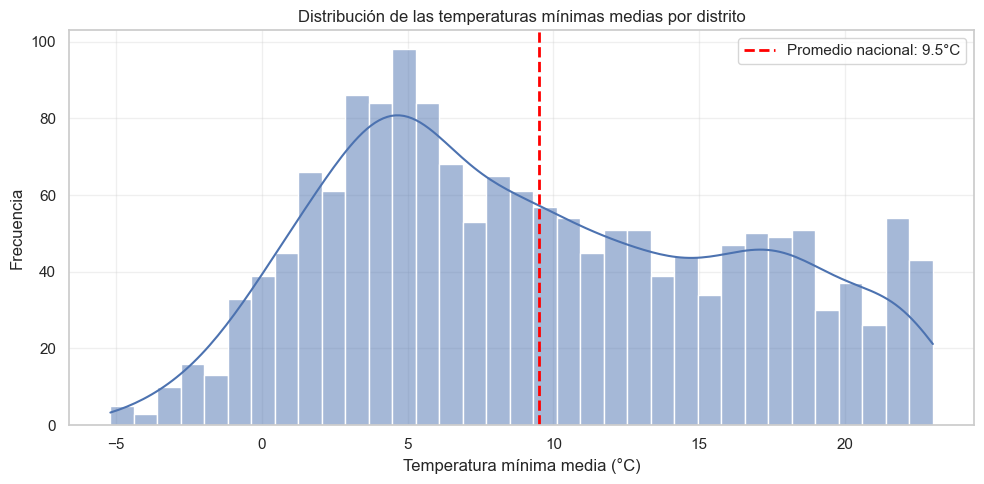

In [83]:
# Distribución de las temperaturas mínimas medias por distrito
plt.figure(figsize=(10,5))
sns.histplot(zonal_mean['mean'], kde=True, bins=35)

# Línea vertical para el promedio nacional
mean_value = zonal_mean['mean'].mean()
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, 
            label=f'Promedio nacional: {mean_value:.1f}°C')

plt.xlabel('Temperatura mínima media (°C)')
plt.ylabel('Frecuencia')
plt.title('Distribución de las temperaturas mínimas medias por distrito')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('./outputs/histograma_tmin_media.png', dpi=300, bbox_inches='tight')
plt.show()

Clasificación de los principales 15 distritos más fríos y más cálidos (Tablas y visualizaciones)

In [88]:
# Top 15 de los distritos más fríos (menor Tmin media)
top15_cold = zonal_mean.nsmallest(15, 'mean')[['DISTRITO','mean','percentile_10']]
top15_cold['variabilidad'] = top15_cold['mean'] - top15_cold['percentile_10']

# Top 15 de los distritos más cálidos (mayor Tmin media)
top15_hot = zonal_mean.nlargest(15, 'mean')[['DISTRITO','mean','percentile_90']]
top15_hot['variabilidad'] = top15_hot['percentile_90'] - top15_hot['mean']

print('Top 15 de los distritos más fríos (por Tmin media)')
display(top15_cold.style.format({
    'mean': '{:.2f}°C',
    'percentile_10': '{:.2f}°C', 
    'variabilidad': '{:.2f}°C'
}).background_gradient(cmap='Blues', subset=['mean', 'percentile_10']))

print('Top 15 de los distritos más cálidos (por Tmin media)')
display(top15_hot.style.format({
    'mean': '{:.2f}°C',
    'percentile_90': '{:.2f}°C',
    'variabilidad': '{:.2f}°C'
}).background_gradient(cmap='YlOrRd', subset=['mean', 'percentile_90']))

#Guardar ambas tablas como archivo CSV
top15_cold.to_csv('./outputs/top15_distritos_frios_detalle.csv', index=False, encoding='utf-8')
top15_hot.to_csv('./outputs/top15_distritos_calidos_detalle.csv', index=False, encoding='utf-8')

Top 15 de los distritos más fríos (por Tmin media)


,DISTRITO,mean,percentile_10,variabilidad
200,CAPAZO,-5.19°C,-6.46°C,1.27°C
1514,SUSAPAYA,-5.16°C,-8.51°C,3.35°C
1544,TARATA,-5.00°C,-6.66°C,1.66°C
1559,TICACO,-4.42°C,-6.33°C,1.91°C
1271,SAN ANTONIO DE CHUCA,-4.39°C,-5.28°C,0.89°C
192,CANDARAVE,-4.36°C,-6.96°C,2.60°C
408,CONDOROMA,-4.12°C,-4.71°C,0.58°C
1064,PARATIA,-4.09°C,-4.72°C,0.63°C
220,CARUMAS,-3.41°C,-6.08°C,2.67°C
1330,SAN JUAN DE TARUCANI,-3.34°C,-4.67°C,1.33°C


Top 15 de los distritos más cálidos (por Tmin media)


,DISTRITO,mean,percentile_90,variabilidad
935,MORONA,23.01°C,23.29°C,0.28°C
1671,YAGUAS,23.01°C,23.14°C,0.13°C
1215,RAMON CASTILLA,22.97°C,23.04°C,0.07°C
1075,PASTAZA,22.92°C,23.07°C,0.15°C
1090,PEBAS,22.88°C,22.96°C,0.08°C
774,LAS AMAZONAS,22.81°C,22.92°C,0.11°C
667,IQUITOS,22.78°C,22.87°C,0.09°C
1175,PUTUMAYO,22.78°C,22.96°C,0.18°C
662,INDIANA,22.76°C,22.86°C,0.10°C
1700,YAVARI,22.75°C,22.97°C,0.22°C


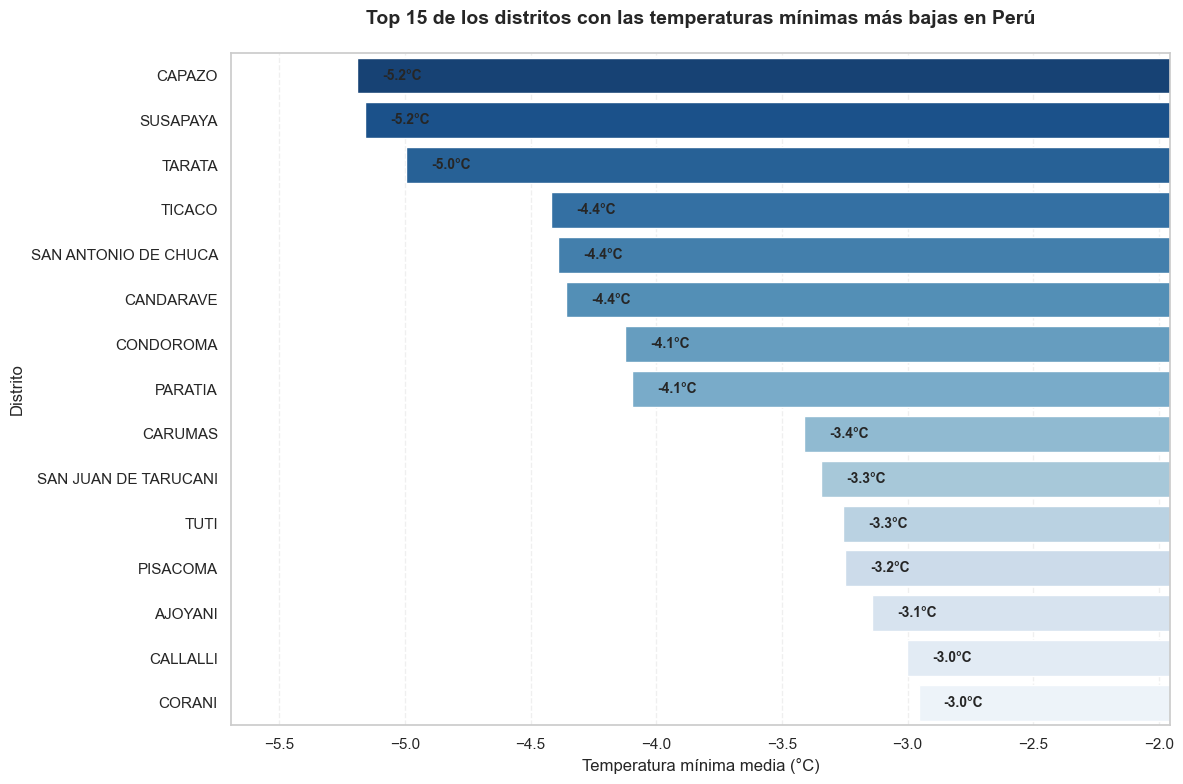

In [84]:
# Top 15 de los distritos con las temperaturas mínimas más bajas en Perú
top_frio = zonal_mean.sort_values("mean").head(15)

plt.figure(figsize=(12, 8))
bars = sns.barplot(data=top_frio, y="DISTRITO", x="mean", 
                   palette=sns.color_palette("Blues_r", n_colors=15))

plt.title("Top 15 de los distritos con las temperaturas mínimas más bajas en Perú\n", 
          fontsize=14, fontweight='bold')
plt.xlabel("Temperatura mínima media (°C)", fontsize=12)
plt.ylabel("Distrito", fontsize=12)

# Agregar valores en las barras
for i, (value, distrito) in enumerate(zip(top_frio['mean'], top_frio['DISTRITO'])):
    plt.text(value + 0.1, i, f'{value:.1f}°C', 
             va='center', fontsize=10, fontweight='bold')

# Ajustar límites 
plt.xlim(top_frio['mean'].min() - 0.5, top_frio['mean'].max() + 1)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('./outputs/top15_distritos_mas_frios.png', dpi=300, bbox_inches='tight')
plt.show()

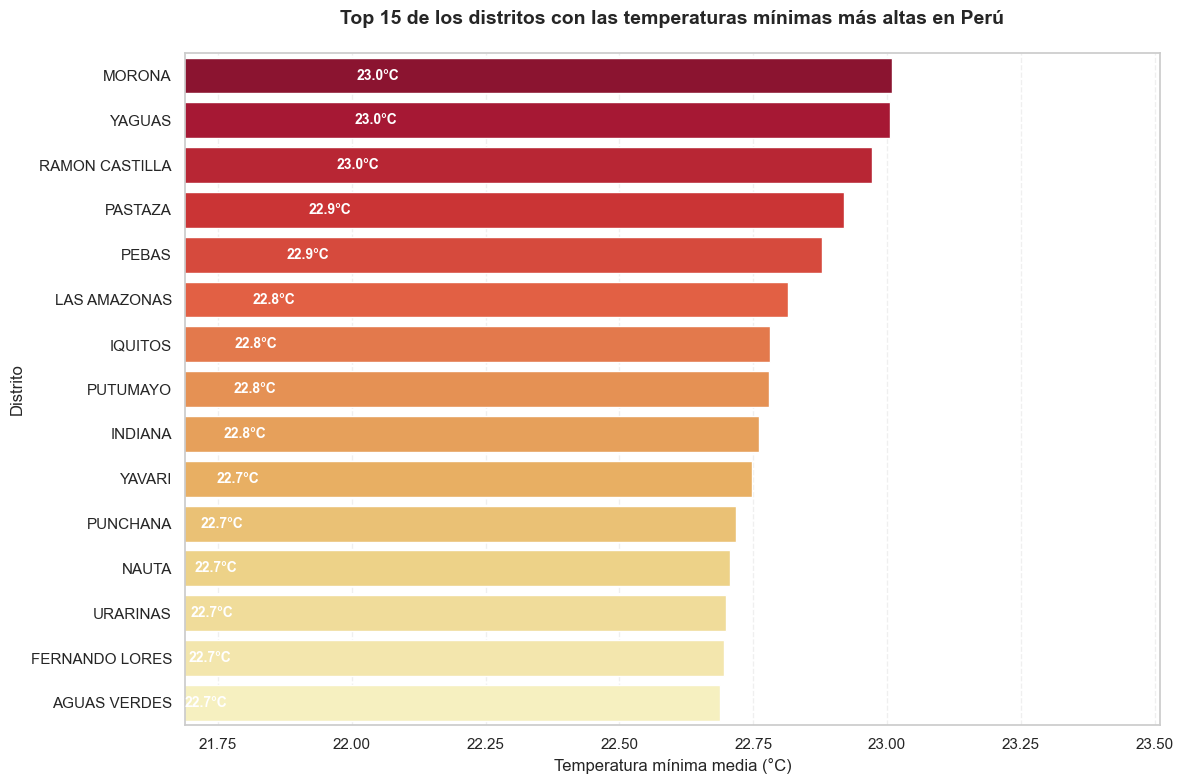

In [85]:
# Top 15 de los distritos con las temperaturas mínimas más altas en el Perú
top_calido = zonal_mean.sort_values("mean", ascending=False).head(15)

plt.figure(figsize=(12, 8))
bars = sns.barplot(data=top_calido, y="DISTRITO", x="mean", 
                   palette=sns.color_palette("YlOrRd_r", n_colors=15))

plt.title("Top 15 de los distritos con las temperaturas mínimas más altas en Perú\n", 
          fontsize=14, fontweight='bold')
plt.xlabel("Temperatura mínima media (°C)", fontsize=12)
plt.ylabel("Distrito", fontsize=12)

# Agregar valores en las barras
for i, (value, distrito) in enumerate(zip(top_calido['mean'], top_calido['DISTRITO'])):
    plt.text(value - 1, i, f'{value:.1f}°C', 
             va='center', fontsize=10, fontweight='bold', color='white')

# Ajustar límites 
plt.xlim(top_calido['mean'].min() - 1, top_calido['mean'].max() + 0.5)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('./outputs/top15_distritos_mas_calidos.png', dpi=300, bbox_inches='tight')
plt.show()

Mapa coroplético de Tmin media a nivel de distrito

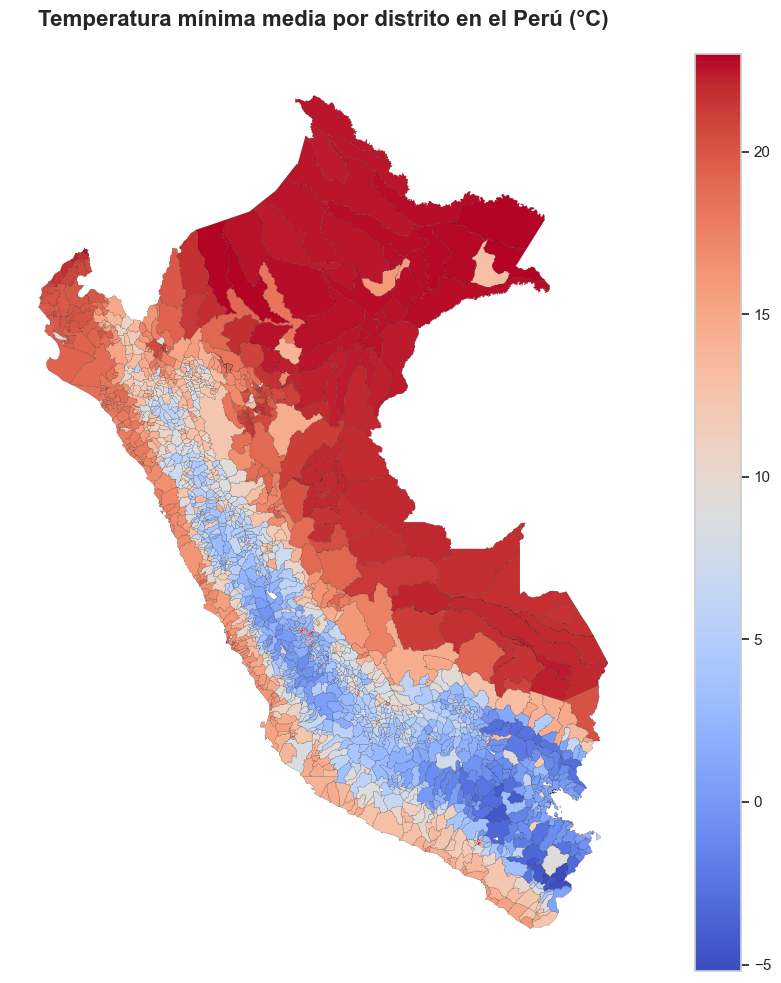

Distritos con datos faltantes: 69/1873 (3.7%)


In [81]:
# Merge entre el GeoDataFrame original y zonal_mean
map_merge = maps.merge(zonal_mean, on='DISTRITO', how='left')
map_merge = gpd.GeoDataFrame(map_merge, geometry='GEOMETRY', crs=maps.crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Crear el mapa coroplético
mapa = map_merge.plot(column='mean', 
                     cmap='coolwarm', 
                     legend=True, 
                     ax=ax,
                     edgecolor='black',  # Bordes suaves para definir distritos
                     linewidth=0.1,      # Línea muy fina
                     missing_kwds={'color': 'lightgrey', 'edgecolor': 'red', 'hatch': '///'})  # Datos faltantes

ax.set_title('Temperatura mínima media por distrito en el Perú (°C)', 
             fontsize=16, fontweight='bold', pad=20)

# Agregar la leyenda
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.05, 0.5))  # Mover leyenda a la derecha
    legend.set_title('Temperatura\n(°C)', prop={'size': 10})

plt.axis("off")

plt.tight_layout()
plt.savefig('./outputs/choropleth_tmin_mean.png', dpi=300, bbox_inches='tight')
plt.show()

# Verificar datos faltantes
missing_data = map_merge['mean'].isna().sum()
total_districts = len(map_merge)
print(f"Distritos con datos faltantes: {missing_data}/{total_districts} ({missing_data/total_districts*100:.1f}%)")

Se generan CSVs con resultados por banda y con el promedio distrital.

In [82]:
# Tabla descargable con los datos principales
tabla_descargable = zonal_mean[['DISTRITO', 'mean']].sort_values('mean')
tabla_descargable['mean'] = tabla_descargable['mean'].round(2)
tabla_descargable.columns = ['Distrito', 'Tmin_Media_C']

# Guardar como CSV
tabla_descargable.to_csv('./outputs/temperaturas_minimas_distritos.csv', index=False, encoding='utf-8')

print(f"Tabla guardada con {len(tabla_descargable)} distritos")
print("Primeras filas:")
print(tabla_descargable.head(10))

Tabla guardada con 1721 distritos
Primeras filas:
                  Distrito  Tmin_Media_C
200                 CAPAZO         -5.19
1514              SUSAPAYA         -5.16
1544                TARATA         -5.00
1559                TICACO         -4.42
1271  SAN ANTONIO DE CHUCA         -4.39
192              CANDARAVE         -4.36
408              CONDOROMA         -4.12
1064               PARATIA         -4.09
220                CARUMAS         -3.41
1330  SAN JUAN DE TARUCANI         -3.34
